# Perceptual loss - Style transfer in a single forward pass

Paper:https://arxiv.org/abs/1603.08155


Idea: Train a transformation network which transforms an input image X into an image X' in the style of a style image S using a single forward pass, without having to solve an optimization problem for each style transfer.

To compute the loss, use a pretrained model which assesses the perceptual quality of the generated image. This essentially evaluates the model in the feature space.



In [63]:
"""
# TODOs:
- Transformation of the transform model's output

"""

"\n# TODOs:\n\n- Input image transformation (content/ target image) for transform network\n- Transformation of the transform model's output\n- Training loop: Pass loss from loss network back into transform network, compute gradients of transform network only.\n- Residual block addition operation\n\n"

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input
from IPython.display import Image, display

from PIL import Image as ImagePIL

# Image preprocessing

Images in:
- Input image X -> image we want to transform
- Content image C -> Image from which we want the content. Isn't that X for style transfer??
- Style image S -> Image which contains the style we want to extract.


## Preprocessing steps

content image (PIL)

        |
        |
        V
Some tensor ?
        |
        |
        V
Transform network
        |
        |
        V
Some tensor
        |
        |
        V       
Loss network (VGG16)
    |   |   |   |
    V   V   V   V
    Loss components from different layers
    

In [2]:
# content image (PIL)
#        |
#        |
#        V
# Some tensor 
#        |
#        |
#        V
# Transform network
#        |
#        |
#        V
# Some tensor
#        | |
#        | |
#        V V      
# Loss network (VGG16)
#    |   |   |   |
#    V   V   V   V
#    Loss components from different layers

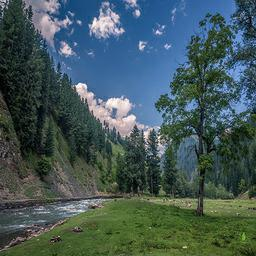

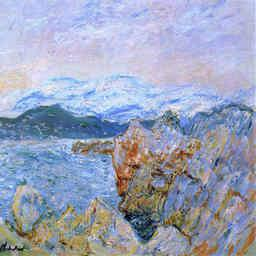

In [2]:
# Load images
content_image = "0cae98323f"
style_image = "732d76a469"

base_path_content = "../../data/art/photo_jpg/"
base_path_style = "../../data/art/monet_jpg/"


content_image_path = base_path_content + content_image + ".jpg"
style_image_path = base_path_style + style_image + ".jpg"

display(Image(content_image_path))
display(Image(style_image_path))

In [78]:
# Make tf dataset from content images.
image_size = (256,256)
batch_size = 4


base_path_content = "../../data/art/photo_jpg/"
base_path_content = "../../data/art/testLarge/"

#content_image_path = base_path_content + content_image + ".jpg"
train = keras.preprocessing.image_dataset_from_directory(
    base_path_content,
    validation_split=0.0,
    #subset="training",
    labels=None,
    seed=1581,
    image_size=image_size,
    batch_size=batch_size
)


""" validation = keras.preprocessing.image_dataset_from_directory(
    base_path_content,
    validation_split=0.2,
    subset="validation",
    labels=None,
    seed=1581,
    image_size=image_size,
    batch_size=batch_size
) """


Found 24 files belonging to 1 classes.


' validation = keras.preprocessing.image_dataset_from_directory(\n    base_path_content,\n    validation_split=0.2,\n    subset="validation",\n    labels=None,\n    seed=1581,\n    image_size=image_size,\n    batch_size=batch_size\n) '

In [79]:
# Preprocess and postprocess images
def get_and_scale_image(image_path):
    """
    Loads and scales a .jpg image.
    Returns a tf.tensor with batch dimension, scaled to [0,1].
    """

    image = keras.preprocessing.image.load_img(image_path)
    image = keras.preprocessing.image.img_to_array(image)
    
    # Scale
    image = image / 255.0

    # Adds batch dimension. Shape is (batch, height, width, colour)
    image = np.array([image])

    # Convert to tensorflow tensor
    image = tf.convert_to_tensor(image)

    return image


In [5]:
img = keras.preprocessing.image.load_img(content_image_path)
img = keras.preprocessing.image.img_to_array(img)

# Adds batch dimension. Shape is (batch, height, width, colour)
img = np.expand_dims(img, axis=0)
# Convert RGB to BGR and zero centre each colour channel according to ImageNet.
# Does not perform scaling.
# Convert to tensorflow tensor
img = tf.convert_to_tensor(img)

# Define transform and loss networks

## Transform network
Use Keras Functional API to construct network, since we need the residual blocks.

In [80]:
# Create reflection padding layer
class ReflectionPadding2D(keras.layers.Layer):
    def __init__(self):
        super(ReflectionPadding2D, self).__init__()
    
    def call(self, inputs):
        paddings = tf.constant([[0,0],[40,40],[40,40],[0,0]])

        return tf.pad(inputs, paddings, "REFLECT")

In [81]:
# Residual block
def residual_block(n_filters, name, inputs, stride=(1,1)):
    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, activation="relu", name='Conv1ResidualBlock_' + name)(inputs)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, name='Conv2ResidualBlock_' + name)(x)
    x = layers.BatchNormalization(scale=False)(x)

    # Crop the input to match sizes and add activations.
    inputs = tf.keras.layers.Cropping2D(cropping=((2,2),(2,2)), data_format=None)(inputs)
    x = layers.Add()([x, inputs])
    x = activations.relu(x)
    return x


# Test
x = tf.ones(shape=(1,84,84,128))
print(x.shape)

y = residual_block(128,"1", x)
print(y.shape)

(1, 84, 84, 128)
(1, 80, 80, 128)


In [82]:
### Transform network ###
def get_uncompiled_model():

    inputs = keras.Input(shape=(256,256,3), name="InputLayer")

    #print(inputs)
    # Reflection padding
    padding = ReflectionPadding2D()
    padding._name = "Reflection"
    x = padding(inputs)
   
    x = layers.Conv2D(filters=32, kernel_size=(9,9),strides=(1,1), activation="relu", padding='same', name="Conv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv2")(x) 
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=False)(x)

    # Residual blocks
    x = residual_block(128,"1", x)
    x = residual_block(128,"2", x)
    x = residual_block(128,"3", x)
    x = residual_block(128,"4", x)
    x = residual_block(128,"5", x)

    # Deconvolutions
    x = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='Deconv2')(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1,1), activation="tanh", padding='same', name="Conv4")(x)
    outputs = layers.BatchNormalization(scale=False)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Transform_network")

In [80]:
#transform_network.summary()
#keras.utils.plot_model(transform_network, "Transform_network.png", show_shapes=True)

In [9]:
### Debugging
def get_test_model():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")
    
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), padding='same', name="Conv1")(inputs)
    x = activations.relu(x, name="ReLU1")
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', name="Conv2")(x)
    x = activations.relu(x, name="ReLU2")
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', name="Deconv1")(x)
    x = activations.relu(x, name="ReLU11")
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv2")(x) 
    outputs = activations.tanh(x, name="tanh")
    x = layers.BatchNormalization(scale=False)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Test_network")

test_model = get_test_model()
#test_model.summary()

## Loss network
Use pretrained VGG16.

In [83]:
# Loss network
# Input: 224x224 -> Do I have to resize the input image from 256x256 or does the model not care?
loss_net = vgg16.VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256,256,3)))
loss_net_outputs = dict([(layer.name, layer.output) for layer in loss_net.layers])

loss_net_activations = keras.Model(inputs=loss_net.inputs, outputs=loss_net_outputs)

In [257]:
#loss_net.summary()

# Define loss function

In [84]:
# Hashtables: layer -> [height, width, channels]

style_layers = {
    "block1_conv2": [256,256,64],
    "block2_conv2": [128,128,128],
    "block3_conv3": [64,64,256],
    "block4_conv3" : [32,32,512]
}
content_layers = {"block3_conv3": [64,64,256]}

In [85]:
# Feature loss (content loss)

# Define input image shape
channels = 3
height = 256
width = 256

def compute_content_loss(generated, content, dimensions):
    """
    Computes the content loss from the given features.
    Equation 2 in paper.

    Args:
    generated:  Tensor feature map of the generated image.
    content:    Tensor feature map of the content image.
    dimensions: List of layer dimensions [height, width, channels]
    """

    height, width, channels = dimensions[0], dimensions[1], dimensions[2]
    scaling_factor = (int(height/4) * int(width/4) * channels) # H, W, C

    # Sum over all elements to get loss. Here the sum is over the squared euclidian norm.
    content_reconstruction_loss =  tf.math.reduce_sum(tf.square(generated - content)) / scaling_factor
    return content_reconstruction_loss


def gram_matrix(x):
    """
    Computes the gram matrix.
    y = xT * x
    """
    x = tf.transpose(x, (2,0,1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def compute_style_loss(generated, style, dimensions):
    """
    Compute style loss for one layer.
    """
    
    # Dimensions
    height, width, channels = dimensions[0], dimensions[1], dimensions[2] 
    scaling_factor = (channels * height * width)**2

    generated = gram_matrix(generated)
    style = gram_matrix(style)
    res = tf.reduce_sum(tf.square(generated - style)) / scaling_factor
    return res


### TEST: Gram matrix
x = tf.ones(shape=(256,256,3)) # Colour image
y = gram_matrix(x)
print(x.shape, y.shape)

(256, 256, 3) (3, 3)


In [86]:
# TODO: Add weights? See paper page 4
def compute_perceptual_loss(generated_image, content_image, style_image):
    """
    Computes the loss with the loss network.

    Args:
    tf.tensors, scaled to [0,1] with dim (b,h,w,c), RGB.
    """
    
    # Combine input tensors to make one pass with all in parallel.
    input_tensors = tf.concat([generated_image, content_image, style_image], axis=0)

    # Preprocess input_tensors for vgg16. Expects range [0, 255]
    input_tensors = tf.keras.applications.vgg16.preprocess_input(input_tensors*255)

    # Forward pass to get loss from loss network.
    features = loss_net_activations(input_tensors, training=False)

    # Initialize loss
    loss = tf.zeros(shape=())

    # Compute content loss
    for content_layer in content_layers.keys():
        layer_features = features[content_layer]
        generated_features = layer_features[0:,:,:]
        content_features = layer_features[1,:,:,:]
        loss += compute_content_loss(generated_features, content_features, content_layers[content_layer])

    # Compute style loss
    for style_layer in style_layers.keys():
        layer_features = features[style_layer]
        generated_features = layer_features[0,:,:,:]
        style_features = layer_features[2,:,:,:]
        loss += compute_style_loss(generated_features, style_features, style_layers[style_layer])

    return loss

In [14]:
# Pixel loss
def compute_pixel_loss(generated_image, content_image, style_image):
    #print(tf.math.reduce_min(content_image), tf.math.reduce_max(content_image))
    #print(tf.math.reduce_min(generated_image), tf.math.reduce_max(generated_image))
    for img in content_image:
        print(tf.math.reduce_min(img), tf.math.reduce_max(img))
        break
    return tf.reduce_sum(tf.square(content_image - generated_image))


In [94]:
transform_network = get_uncompiled_model()
#transform_network = get_test_model()

@tf.function
def compute_loss_and_grads(content_image, style_image):
    """
    Takes in content and style images as tf.tensors with batch dimension
    and scaled to range [0,1].
    """
    
    with tf.GradientTape() as tape:

        # Forward pass
        generated_image = transform_network(content_image, training=True)
        
        #tf.print(tf.reduce_min(generated_image[0,:,:,:]), tf.reduce_max(generated_image[0,:,:,:]))
        #tf.print(tf.reduce_min(content_image[0,:,:,:]), tf.reduce_max(content_image[0,:,:,:]))
        #tf.print(tf.reduce_min(style_image[0,:,:,:]), tf.reduce_max(style_image[0,:,:,:]))

        # Clip output generated_image to range [-1,1]
        # If used, images tend to be less colourful
        #generated_image = tf.clip_by_value(generated_image, -1.0, 1.0)

        # Convert to range [0,1]
        generated_image = ((generated_image * 0.5) + 0.5)

        # Get loss
        loss = compute_perceptual_loss(generated_image, content_image, style_image)
        #loss = compute_pixel_loss(generated_image, content_image, style_image)

    # Get gradients and upate weights
    grads = tape.gradient(loss, transform_network.trainable_weights)
    optimizer.apply_gradients(zip(grads, transform_network.trainable_weights))
    return loss

## Build training loop


In [95]:

transform_network = get_uncompiled_model()
#transform_network = get_test_model()
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 100,
    decay_rate = 0.96,
    staircase = True
)

optimizer = keras.optimizers.Adam(learning_rate=0.001) # Was: 0.001
epochs = 5


## Custom training loop from scratch

# Load style image
print("Loading style image...")
style_image_name = "732d76a469"

# Load style image as tf.tensor, scaled.
style_image = get_and_scale_image("../../data/art/monet_jpg/"+style_image_name+".jpg")

for epoch in range(epochs):
    print("Running epoch %d / %d" %(epoch+1, epochs))
    for step, img in enumerate(train):
        
        # Scale image to range [0,1]
        img = img / 255.0

        loss = compute_loss_and_grads(img, style_image)
        
        # Print current batch-wise loss
        if step % 2 == 0:
            print("Current loss for one batch at step {:.0f}: {:.2f}".format(step, loss))
            #transform_network.save_weights("models/latest/ckpt")


# Save final model          
#transform_network.save("models/transform_model-testLarge-epochs50-batchsize4", overwrite=False)

Loading style image...
Running epoch 1 / 5


2021-12-07 17:16:38.769219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Current loss for one batch at step 0: 42141700096.00
Current loss for one batch at step 2: 334740422656.00
Current loss for one batch at step 4: 45887471616.00
Running epoch 2 / 5
Current loss for one batch at step 0: 32836747264.00
Current loss for one batch at step 2: 21533726720.00
Current loss for one batch at step 4: 77474906112.00
Running epoch 3 / 5
Current loss for one batch at step 0: 57939140608.00
Current loss for one batch at step 2: 11426263040.00
Current loss for one batch at step 4: 63685181440.00
Running epoch 4 / 5
Current loss for one batch at step 0: 7787792896.00
Current loss for one batch at step 2: 36187500544.00
Current loss for one batch at step 4: 37588262912.00
Running epoch 5 / 5
Current loss for one batch at step 0: 29390434304.00
Current loss for one batch at step 2: 12380674048.00
Current loss for one batch at step 4: 6426380800.00


In [17]:
def show_image(image_name):
    """
    Displays selected image.
    """
    base_path = "../../data/art/photo_jpg/"

    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")  
    display(image)

In [54]:
def generate_image(image_name):
    """
    Runs inference with selected image and displays result.
    """

    base_path = "../../data/art/photo_jpg/"

    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")  
    image = keras.preprocessing.image.img_to_array(image)
    
    # Scale
    image = image / 255.0

    # Adds batch dimension. Shape is (batch, height, width, colour)
    image = np.array([image])

    # Convert to tensorflow tensor
    image = tf.convert_to_tensor(image)   
    generated_image = transform_network(image, training=False)
    tf.print(tf.math.reduce_min(generated_image), tf.math.reduce_max(generated_image))

    generated_image = generated_image.numpy()
    generated_image = np.clip(generated_image, -1.0, 1.0)
    generated_image = ((generated_image * 0.5) + 0.5) 
    generated_image = generated_image * 255

    # Remove batch dimension
    generated_image = generated_image.reshape((256,256,3))

    print(generated_image.min(), generated_image.max())

    generated_image = ImagePIL.fromarray(np.uint8(generated_image)).convert('RGB')
    display(generated_image)


-1.07549047 1.01949453
0.0 255.0


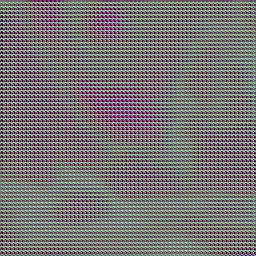

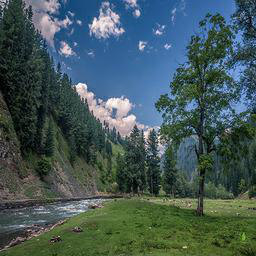

In [96]:
test_image = "0cae98323f"
generate_image(test_image)
show_image(test_image)

In [69]:
# File format: transform_model-debug-
#transform_network.save("models/transform_model-debug-1000", overwrite=False)

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/transform_model-debug-1000/assets


INFO:tensorflow:Assets written to: models/transform_model-debug-1000/assets


# Debugging

The forward pass on the transform network trained with the perceptual loss produces outputs that are massively out of the expected range of [-1,1]. Why?

- Loss function computation correct?

- a

In [70]:
transform_network = keras.models.load_model("models/transform_model-debug-1000epochs-batchsize2")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)